In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('../../src'))
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)

/home/enis/projects/nna/src


In [2]:
import numpy as np 
from numpy import linspace
import pandas as pd


from datetime import datetime,timedelta
from pathlib import Path


import matplotlib.pyplot as plt
import matplotlib as mpl


In [3]:
from pre_process_func import read_queue
from fileUtils import read_file_properties
from labeling_utils import load_labels

from visUtils import file2TableDict,createTimeIndex#,get_cycle



In [4]:
flder="/home/enis/projects/nna/data/"

files_list_path=flder+"mp3files.txt"
fileswlen_path = flder+"mp3files_wlen.txt"

# files_list_path=flder+"flacfiles.txt"
# fileswlen_path = flder+"flacfiles_wlen.txt"

coordinates_fpath= flder + "NNA_recording_devices.csv"

In [5]:
file_properties_df=pd.read_pickle("../../data/stinchcomb_dataV1.pkl")

all_areas=sorted(pd.unique(file_properties_df.site_id.values))

In [6]:
# PARAMS
# FREQS to reduce results 
dataFreq="10S"
# freq="T"
freq="10S"

# clipping threshold
threshold=0.01  # if x <= then 0

# possible places to pick
# sorted(pd.unique(file_properties_df.site_id.values))
# areas to be visualized

# delete older than 2016
fromtime=datetime(2016, 1, 1, 0)

# selected_areas=["15","21","22","27","31","35","37","48",]
# selected_areas=['05-Colville5',
# '19-Itkillik2',
# '04-Colville4',
# # '20-Umiat', # old data
# '03-OceanPt',
# '02-Colville2',
# '01-Itkillik',
# '09-USGS'
#                ]
selected_areas=all_areas[1:2]

id2name={}
id2name['09-USGS']="USGS"
id2name['19-Itkillik2']="Itkilik 2"
id2name['01-Itkillik']="Itkilik 1"
id2name['02-Colville2']="Colville 2"
id2name['03-OceanPt']="Ocean Pt"
id2name['04-Colville4']="Colville 4"
id2name['05-Colville5']="Colville 5"


tag_set=["Songbird","Water Bird","Insect","Running Water","Rain","Cable","Wind","Aircraft"]


In [7]:
#important to keep them in order
file_properties_df.sort_values(by=['timestamp'],inplace=True)

# delete olde r than 2016
fromtime=datetime(2016, 1, 1, 0)
file_properties_df=file_properties_df[file_properties_df.timestamp>=fromtime]


In [8]:
# gathered_results_perTag.keys() #<--- all possible ones
model_tag_names=["Neural Net_Songbird",
"Neural Net_Water Bird",
"Neural Net_Insect",
"Neural Net_Running Water",
"Neural Net_Rain",
"Neural Net_Cable",
"Neural Net_Wind",
"Neural Net_Aircraft",]


In [9]:
# gathered_results_perTag['Neural Net_Songbird'][Path('/tank/data/nna/real/stinchcomb/05-Colville5/2016/CLVL5_20160602_163306.MP3')]

In [24]:
df_count,df_sums=df_dict[areaName]


In [30]:
len(df_sums.index)%1440.0

751680

In [31]:
def load_data():

    globalcolumns=model_tag_names#selected_areas+weather_cols

    globalindex,all_start,all_end=createTimeIndex(selected_areas,file_properties_df,freq)


    # inference_file="/home/enis/projects/nna/notebooks/Visualizations/Neural Net_Insect_tags_on_real_Dec:6.npy"
    inference_file="/home/enis/projects/nna/results/predictions/8tags_on_8sites_pathV2.npy"
    gathered_results_perTag=np.load(inference_file,allow_pickle=True)[()]


    df_dict,no_result_paths=file2TableDict(selected_areas,model_tag_names,globalindex,globalcolumns,
                        file_properties_df,freq,dataFreq,gathered_results_perTag=gathered_results_perTag,
                                           prob2binaryFlag=False)

    return df_dict,no_result_paths

def getVisData(df_dict,areaName):
    df_count,df_sums=df_dict[areaName]
    if "Nothing" not in df_sums:
        df_sums.insert(0, 'Nothing', 0)

    # make sure we use only full days
    df_sums_short=df_sums[:(len(df_sums.index)-(len(df_sums.index)%8640))]
    df_sums_max=df_sums_short.idxmax(axis=1)

    N=len(model_tag_names)+1
    labelsNames=["Nothing"]+[i.replace("Neural Net_","") for i in model_tag_names]
    labelIds=["Nothing"]+model_tag_names
    mapping = dict(zip(labelIds,range(0,N)))

    df_sums_max=df_sums_max.replace(mapping)
    df_sums_max=df_sums_max.astype(str).astype(int)
    df_sums_max_np=df_sums_max.values.reshape(-1,8640)
    return df_sums_max_np,labelsNames


In [55]:
df_count,df_sums=df_dict[areaName]

# make sure we use only full days
df_sums_short=df_sums[:(len(df_sums.index)-(len(df_sums.index)%8640))]
df_sums_max=df_sums_short.idxmax(axis=1)

N=len(model_tag_names)+1
labelsNames=["Nothing"]+[i.replace("Neural Net_","") for i in model_tag_names]
labelIds=["Nothing"]+model_tag_names
mapping = dict(zip(labelIds,range(0,N)))

df_sums_max=df_sums_max.replace(mapping)
df_sums_max=df_sums_max.astype(str).astype(int)
df_sums_max_np=df_sums_max.values.reshape(-1,8640)


In [66]:
df_sums_max_np.shape

(87, 8640)

In [77]:
yAxisIndex=pd.date_range(df_sums_max.index[0],df_sums_max.index[-1], freq='10D')
# plt.xticks(c, yAxisIndex, rotation='vertical')
len(yAxisIndex)

9

NameError: name 'yAxis' is not defined

In [88]:
# Z = np.random.randint(0,8,(10,1440))
def makeVis(df_sums_max_np,labelsNames,areaName,save=True):
#     cmap=mpl.colors.ListedColormap([plt.get_cmap("tab10")(i) for i in np.unique(df_sums_max_np)])
    df_sums_max_np,labelsNames=getVisData(df_dict,areaName)
    asd=[plt.get_cmap("tab10")(i) for i in np.unique(df_sums_max_np)]
    asd[0]=(1.0,1.0,1.0,1.0)
    cmap=mpl.colors.ListedColormap(asd)

    N=len(np.unique(df_sums_max_np))
    
    fig, (ax0) = plt.subplots(figsize=(25,10),nrows=1)

    Z = df_sums_max_np[:]

    c = ax0.pcolormesh(Z,cmap=cmap)
    ax0.set_title(f'{areaName}',fontsize=28)


    cbar=fig.colorbar(c);
    cbar.set_ticks([i for i in range(N)])
    cbar.set_ticklabels(labelsNames)

    cbar.ax.tick_params(labelsize=20)
    ax0.tick_params(labelsize=22,which="minor")
    ax0.tick_params(labelsize=25,which="major")
    ax0.set_ylabel(f'Days',fontsize=32)
    ax0.set_xlabel(f'10 Seconds',fontsize=32)
    
    yAxisIndex=pd.date_range(df_sums_max.index[0],df_sums_max.index[-1],periods=10,)
    yAxisIndex=[yAxis.strftime("%b-%d") for yAxis in yAxisIndex]
    ax0.set_yticklabels(yAxisIndex, rotation='horizontal')

    fig.tight_layout()
    plt.show()
    if save:
        fig.savefig(f"/home/enis/projects/nna/results/vis/dielPlots/{areaName}_diel_plot_v2"+'.png')



In [12]:
# plt.get_cmap("tab10")(1)

(1.0, 0.4980392156862745, 0.054901960784313725, 1.0)

In [14]:
df_dict,no_result_paths=load_data()


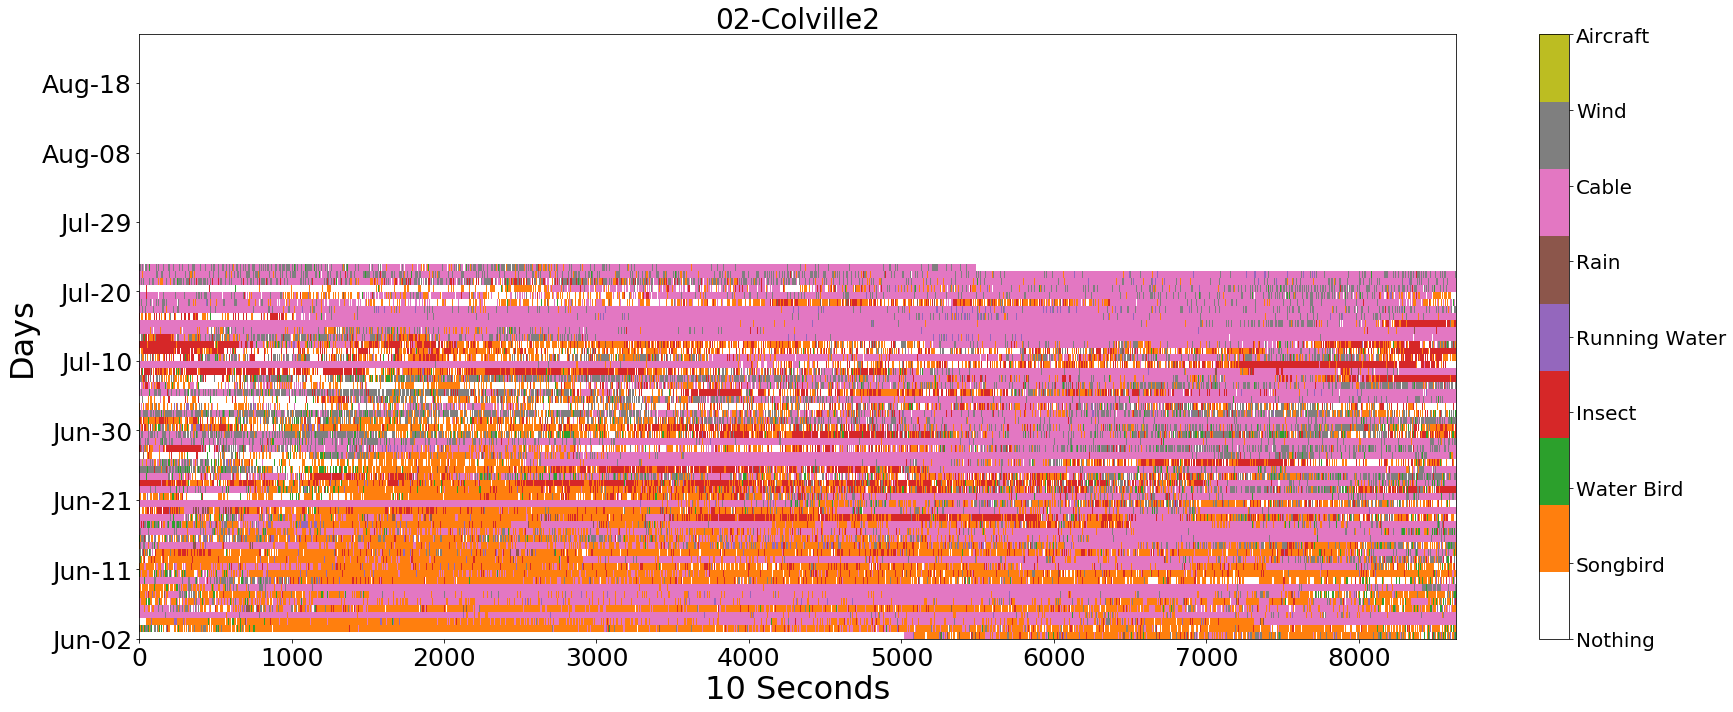

In [89]:
for areaName in selected_areas:
    df_sums_max_np,labelsNames=getVisData(df_dict,areaName)
    makeVis(df_sums_max_np,labelsNames,areaName,save=False)
#     break

In [ ]:
print(" Duration of selected data period:",(all_end-all_start).days,"days")
print(" Starts: {} \n Ends:   {}".format(all_start,all_end))